In [ ]:
import os
import sys
import ctypes

def run_as_admin():
    if sys.platform.startswith('win'):
        app_dir = os.path.dirname(os.path.realpath(sys.argv[0]))
        cmd_args = sys.argv[:]
        cmd_args.insert(0, sys.executable)
        cmd_args = ['"{}"'.format(arg) for arg in cmd_args]
        cmd = '{} -m {}'.format(sys.executable, ' '.join(cmd_args))
        ctypes.windll.shell32.ShellExecuteW(None, "runas", cmd, None, app_dir, 1)

if __name__ == '__main__':
    run_as_admin()


In [72]:
# import libraries
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from PIL import Image
import shutil
import random
import matplotlib.pyplot as plt
import glob
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.metrics import Precision, Recall
from keras.metrics import Metric
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Path to data folder
data_dir = os.path.join(os.getcwd(), 'Brain Tumor MRI')

# Path to processed data
output_dir = os.path.join(os.getcwd(), 'Processed Data')

In [ ]:
# check if folder was created
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
# Iteration by data in folder
for dir_name in os.listdir(data_dir):
    # Create path to folder with images
    dir_path = os.path.join(data_dir, dir_name)
    #Check if item is folder or hidden file
    if os.path.isdir(dir_path) and not dir_name.startswith("."):
        print(f"Processing images in {dir_name}...")
        #Create path to output directory for such type of images
        output_path = os.path.join(output_dir, dir_name)
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        # Iteration by files in folder
        for filename in os.listdir(dir_path):
            # Check if file is mage
            if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
                # Load file, initial processing
                img_path = os.path.join(dir_path, filename)
                with Image.open(img_path) as img:
                    img = img.rotate(90)
                    # Save processed image
                    output_filename = os.path.join(output_path, filename)
                    img.save(output_filename)

In [ ]:
# Input data dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Initial pre processing
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        print(f'Preprocessing of {folder_name}')
        output_folder_path = os.path.join(output_dir, folder_name)
        if not os.path.exists(output_folder_path):
            os.makedirs(output_folder_path)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.jpg'):
                file_path = os.path.join(folder_path, file_name)
                img = cv2.imread(file_path, cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                img = img / 255.0
                output_file_path = os.path.join(output_folder_path, file_name)
                cv2.imwrite(output_file_path, img * 255.0)

## EDA for training set

In [ ]:
# Path to Processed Data
processed_data_path = os.path.join(os.getcwd(), 'Processed Data')

# Paths to train/test and validation sets
train_path = os.path.join(processed_data_path, "train")
val_path = os.path.join(processed_data_path, "validation")
test_path = os.path.join(processed_data_path, "test")

# Split for train/ test and validation sets
train_split = 0.6
test_split = 0.2
val_split = 0.2

# Train, test, validation for paths in processed data
for folder_name in os.listdir(processed_data_path):
    folder_path = os.path.join(processed_data_path, folder_name)
    if os.path.isdir(folder_path):
        train_folder_path = os.path.join(train_path, folder_name)
        val_folder_path = os.path.join(val_path, folder_name)
        test_folder_path = os.path.join(test_path, folder_name)
        os.makedirs(train_folder_path, exist_ok=True)
        os.makedirs(val_folder_path, exist_ok=True)
        os.makedirs(test_folder_path, exist_ok=True)
        
        # List of files and random order
        files = os.listdir(folder_path)
        random.shuffle(files)
        
        
        train_files = files[:int(train_split * len(files))]
        val_files = files[int(train_split * len(files)):int((train_split + val_split) * len(files))]
        test_files = files[int((train_split + val_split) * len(files)):]
        for file_name in train_files:
            src_path = os.path.join(folder_path, file_name)
            dst_path = os.path.join(train_folder_path, file_name)
            shutil.copy(src_path, dst_path)
        for file_name in val_files:
            src_path = os.path.join(folder_path, file_name)
            dst_path = os.path.join(val_folder_path, file_name)
            shutil.copy(src_path, dst_path)
        for file_name in test_files:
            src_path = os.path.join(folder_path, file_name)
            dst_path = os.path.join(test_folder_path, file_name)
            shutil.copy(src_path, dst_path)


In [18]:
# Data check
train_path = os.path.join("Processed Data", "train")

# 
classes = []
num_images = []
dimensions = []
pixel_means = []


for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):
        classes.append(class_name)
        
        class_num_images = 0
        
        class_dimensions = []
        
        class_pixel_means = []
        
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image = plt.imread(image_path)
                height, width = image.shape[:2]
                class_dimensions.append((height, width))
                
                pixel_mean = image.mean()
                class_pixel_means.append(pixel_mean)
                
                class_num_images += 1
        
        num_images.append(class_num_images)
        
        class_avg_height = sum([dim[0] for dim in class_dimensions]) / class_num_images
        class_avg_width = sum([dim[1] for dim in class_dimensions]) / class_num_images
        class_avg_dimension = (class_avg_height, class_avg_width)
        dimensions.append(class_avg_dimension)
        
        class_avg_pixel_mean = sum(class_pixel_means) / class_num_images
        pixel_means.append(class_avg_pixel_mean)

for i, class_name in enumerate(classes):
    print(f"Class {i + 1}: {class_name}")
    print(f"Number of images: {num_images[i]}")
    print(f"Average dimensions: {dimensions[i]}")
    print(f"Average pixel mean: {pixel_means[i]}")
    print()

Class 1: Astrocitoma T1
Number of images: 105
Average dimensions: (522.6857142857143, 514.6952380952381)
Average pixel mean: 42.95838607456881

Class 2: Astrocitoma T1C+
Number of images: 139
Average dimensions: (554.5611510791367, 552.2158273381295)
Average pixel mean: 43.61071428274967

Class 3: Astrocitoma T2
Number of images: 102
Average dimensions: (540.3333333333334, 518.1862745098039)
Average pixel mean: 44.41717035197188

Class 4: Carcinoma T1
Number of images: 39
Average dimensions: (601.2307692307693, 531.0769230769231)
Average pixel mean: 73.59633759873034

Class 5: Carcinoma T1C+
Number of images: 66
Average dimensions: (613.0, 539.9545454545455)
Average pixel mean: 58.366109188614175

Class 6: Carcinoma T2
Number of images: 43
Average dimensions: (569.1162790697674, 504.13953488372096)
Average pixel mean: 38.7277663478673

Class 7: Ependimoma T1
Number of images: 27
Average dimensions: (602.2962962962963, 571.6666666666666)
Average pixel mean: 44.093038381700744

Class 8: 

In [ ]:
# Chart creation
fig, ax = plt.subplots(figsize=(24, 16))
ax.bar(classes, num_images, width=0.5)

# Labels
ax.set_ylabel('Mean no. of images', fontsize=14)
ax.set_title('Mean number of images per class in training set', fontsize=16)

# Axis details
ax.set_xticklabels(classes, rotation=45, ha='right')

# Font
plt.rcParams.update({'font.size': 12})

# Chart show
plt.show()

In [ ]:
# Chart creation
fig, ax = plt.subplots(figsize=(24, 16))
ax.bar(classes, num_images, width=0.5)

# Labels
ax.set_ylabel('Mean no. of images', fontsize=14)
ax.set_title('Mean number of images per class in training set', fontsize=16)

# Axis details
ax.set_xticklabels(classes, rotation=45, ha='right')

# Font
plt.rcParams.update({'font.size': 12})

# Chart show
plt.show()

In [ ]:
# Tuple unpacking
x = range(len(classes))
y1 = [t[0] for t in dimensions]  # wymiar x
y2 = [t[1] for t in dimensions]  # wymiar y

# Chart creation
fig, ax = plt.subplots(figsize=(24, 16))
ax.bar(x, y1, width=0.4, align='center', label='Wymiar x')
ax.bar([i+0.4 for i in x], y2, width=0.4, align='center', label='Wymiar y')

# Axis details
ax.set_xticklabels(classes, rotation=45, ha='right')

# Title and lables
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Average dimensions', fontsize=14)
ax.set_title('Avergae dimensions per class', fontsize=16)
ax.legend()

# Font
plt.rcParams.update({'font.size': 12})

# Chart
plt.show()

In [19]:
class_dict = {class_name: str(i) for i, class_name in enumerate(classes)}

In [20]:
# ustaw ścieżkę do katalogu z obrazami
train_path = os.path.join("Processed Data", "train")

# utwórz pustą tablicę X_train i listę y_train
X_train = []
y_train = []

# przejdź przez katalog i wczytaj każdy obraz
for root, dirs, files in os.walk(train_path):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png') or filename.endswith('.bmp'):
            # wczytaj obraz i przetwórz go
            img = cv2.imread(os.path.join(root, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224)) # przykładowy rozmiar
            X_train.append(img)

            # wczytaj etykietę z nazwy katalogu i dodaj do listy y_train
            label = class_dict[root.split(os.path.sep)[-1]]
            y_train.append(label)

# przekształć listy w tablice numpy
X_train = np.array(X_train)
y_train = np.array(y_train)



In [21]:
print(X_train.shape)
print(y_train.shape)

(2659, 224, 224, 3)
(2659,)


In [8]:
# ustaw ścieżkę do katalogu z obrazami
validation_path = os.path.join("Processed Data", "validation")

# utwórz pustą tablicę X_train i listę y_train
X_val = []
y_val = []

# przejdź przez katalog i wczytaj każdy obraz
for root, dirs, files in os.walk(validation_path):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png') or filename.endswith('.bmp'):
            # wczytaj obraz i przetwórz go
            img = cv2.imread(os.path.join(root, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224)) # przykładowy rozmiar
            X_val.append(img)

            # wczytaj etykietę z nazwy katalogu i dodaj do listy y_train
            label = class_dict[root.split(os.path.sep)[-1]]
            y_val.append(label)

# przekształć listy w tablice numpy
X_val = np.array(X_val)
y_val = np.array(y_val)

print(X_val.shape)
print(y_val.shape)

(894, 224, 224, 3)
(894,)


In [9]:
# ustaw ścieżkę do katalogu z obrazami
test_path = os.path.join("Processed Data", "test")

# utwórz pustą tablicę X_train i listę y_train
X_test = []
y_test = []

# przejdź przez katalog i wczytaj każdy obraz
for root, dirs, files in os.walk(test_path):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png') or filename.endswith('.bmp'):
            # wczytaj obraz i przetwórz go
            img = cv2.imread(os.path.join(root, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224)) # przykładowy rozmiar
            X_test.append(img)

            # wczytaj etykietę z nazwy katalogu i dodaj do listy y_train
            label = class_dict[root.split(os.path.sep)[-1]]
            y_test.append(label)

# przekształć listy w tablice numpy
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(912, 224, 224, 3)
(912,)


## Althought I know that data is imbalanced, let's start with base model for reference

In [156]:
#y_train = to_categorical(y_train, num_classes=44)
#y_val =  to_categorical(y_val, num_classes=44)
#y_test = to_categorical(y_test, num_classes=44)

In [10]:
print(X_val.shape)
print(y_val.shape)

(894, 224, 224, 3)
(894,)


In [158]:
#definition of architecture of model
model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(44, activation='softmax')
])

In [27]:
#metrics
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * ((precision * recall) / (precision + recall + 1e-7))
        self.f1_score = f1_score
        
    def result(self):
        return self.f1_score
        
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1_score = 0.0

In [173]:
#model compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])


In [174]:
#training
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, y_val))


Epoch 1/10
84/84 [==============================] - ETA: 0s - loss: 16.1626 - accuracy: 0.1662 - precision_10: 0.2782 - recall_8: 0.0278 - f1_score: 0.0506

c:\Users\andrz\Anaconda3\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


84/84 [==============================] - 92s 1s/step - loss: 16.1626 - accuracy: 0.1662 - precision_10: 0.2782 - recall_8: 0.0278 - f1_score: 0.0506 - val_loss: 2.4888 - val_accuracy: 0.3736 - val_precision_10: 0.8641 - val_recall_8: 0.0996 - val_f1_score: 0.1785
Epoch 2/10
84/84 [==============================] - 88s 1s/step - loss: 1.8521 - accuracy: 0.5359 - precision_10: 0.8465 - recall_8: 0.3381 - f1_score: 0.4832 - val_loss: 1.7277 - val_accuracy: 0.5940 - val_precision_10: 0.8112 - val_recall_8: 0.5045 - val_f1_score: 0.6221
Epoch 3/10
84/84 [==============================] - 85s 1s/step - loss: 0.9625 - accuracy: 0.7330 - precision_10: 0.8758 - recall_8: 0.6363 - f1_score: 0.7371 - val_loss: 1.6345 - val_accuracy: 0.6432 - val_precision_10: 0.7740 - val_recall_8: 0.5671 - val_f1_score: 0.6546
Epoch 4/10
84/84 [==============================] - 85s 1s/step - loss: 0.5681 - accuracy: 0.8499 - precision_10: 0.9243 - recall_8: 0.7947 - f1_score: 0.8546 - val_loss: 1.4152 - val_accu

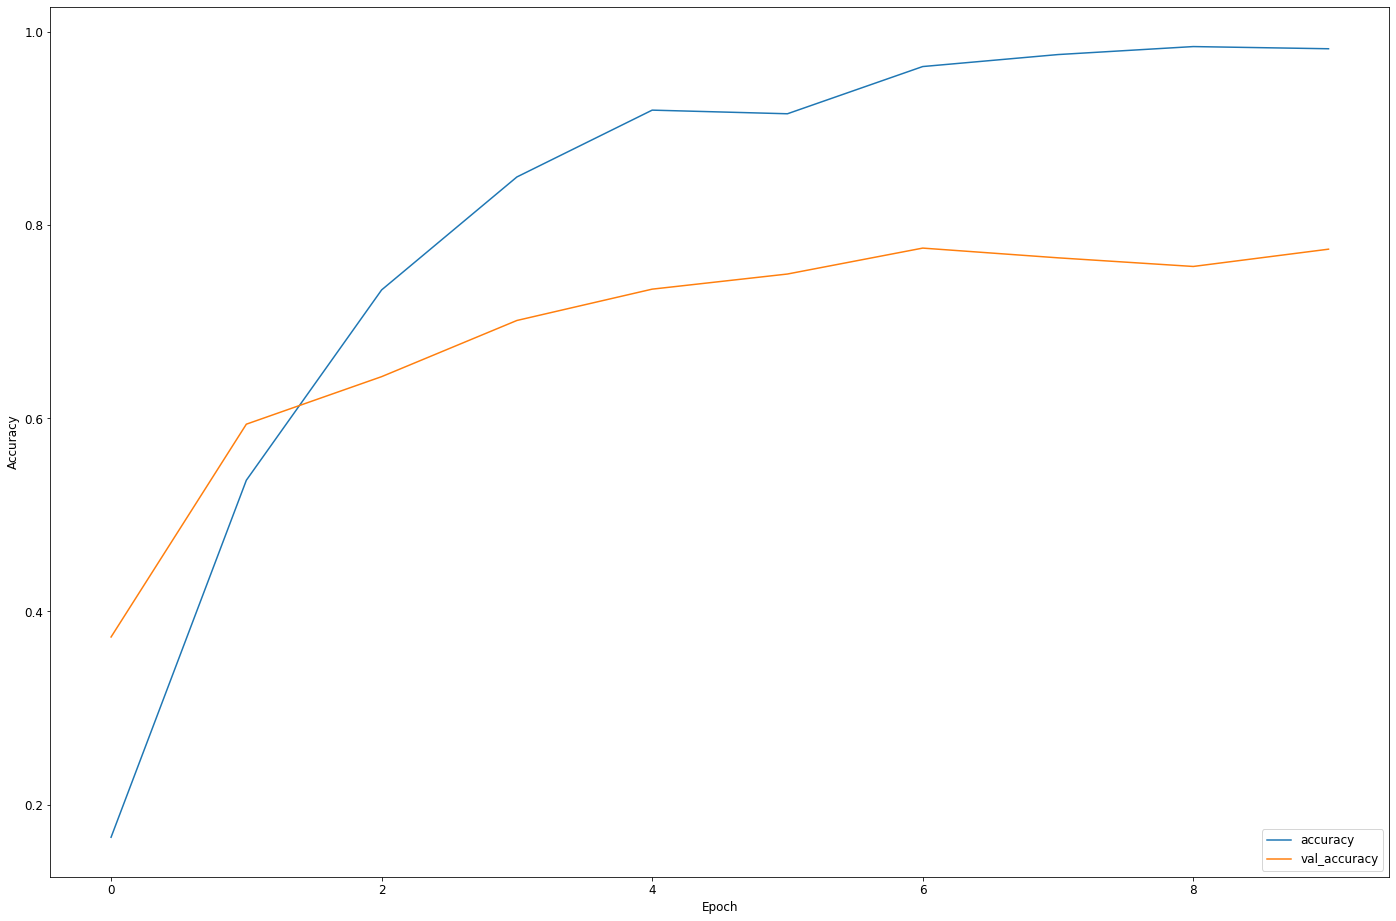

In [176]:
fig, ax = plt.subplots(figsize=(24, 16))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [83]:
y_test_encoded = to_categorical(y_test, num_classes=44)
test_loss, test_acc, test_precision, test_recall, test_f1_score = model.evaluate(X_test, y_test_encoded)

c:\Users\andrz\Anaconda3\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


29/29 [==============================] - 7s 220ms/step - loss: 442.1718 - accuracy: 0.0066 - precision_5: 0.0066 - recall_5: 0.0066 - f1_score: 0.0066


In [84]:
# Uzyskanie predykcji dla zbioru testowego
y_pred = model.predict(X_test)

# Konwersja predykcji i rzeczywistych etykiet na wartości binarne
y_pred_binary = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test_encoded, axis=1)

# Wyświetlenie raportu klasyfikacji
print(classification_report(y_test_binary, y_pred_binary))




              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.00      0.00      0.00        47
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00        11
          16       0.00      0.00      0.00        19
          17       0.00    

c:\Users\andrz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andrz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andrz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


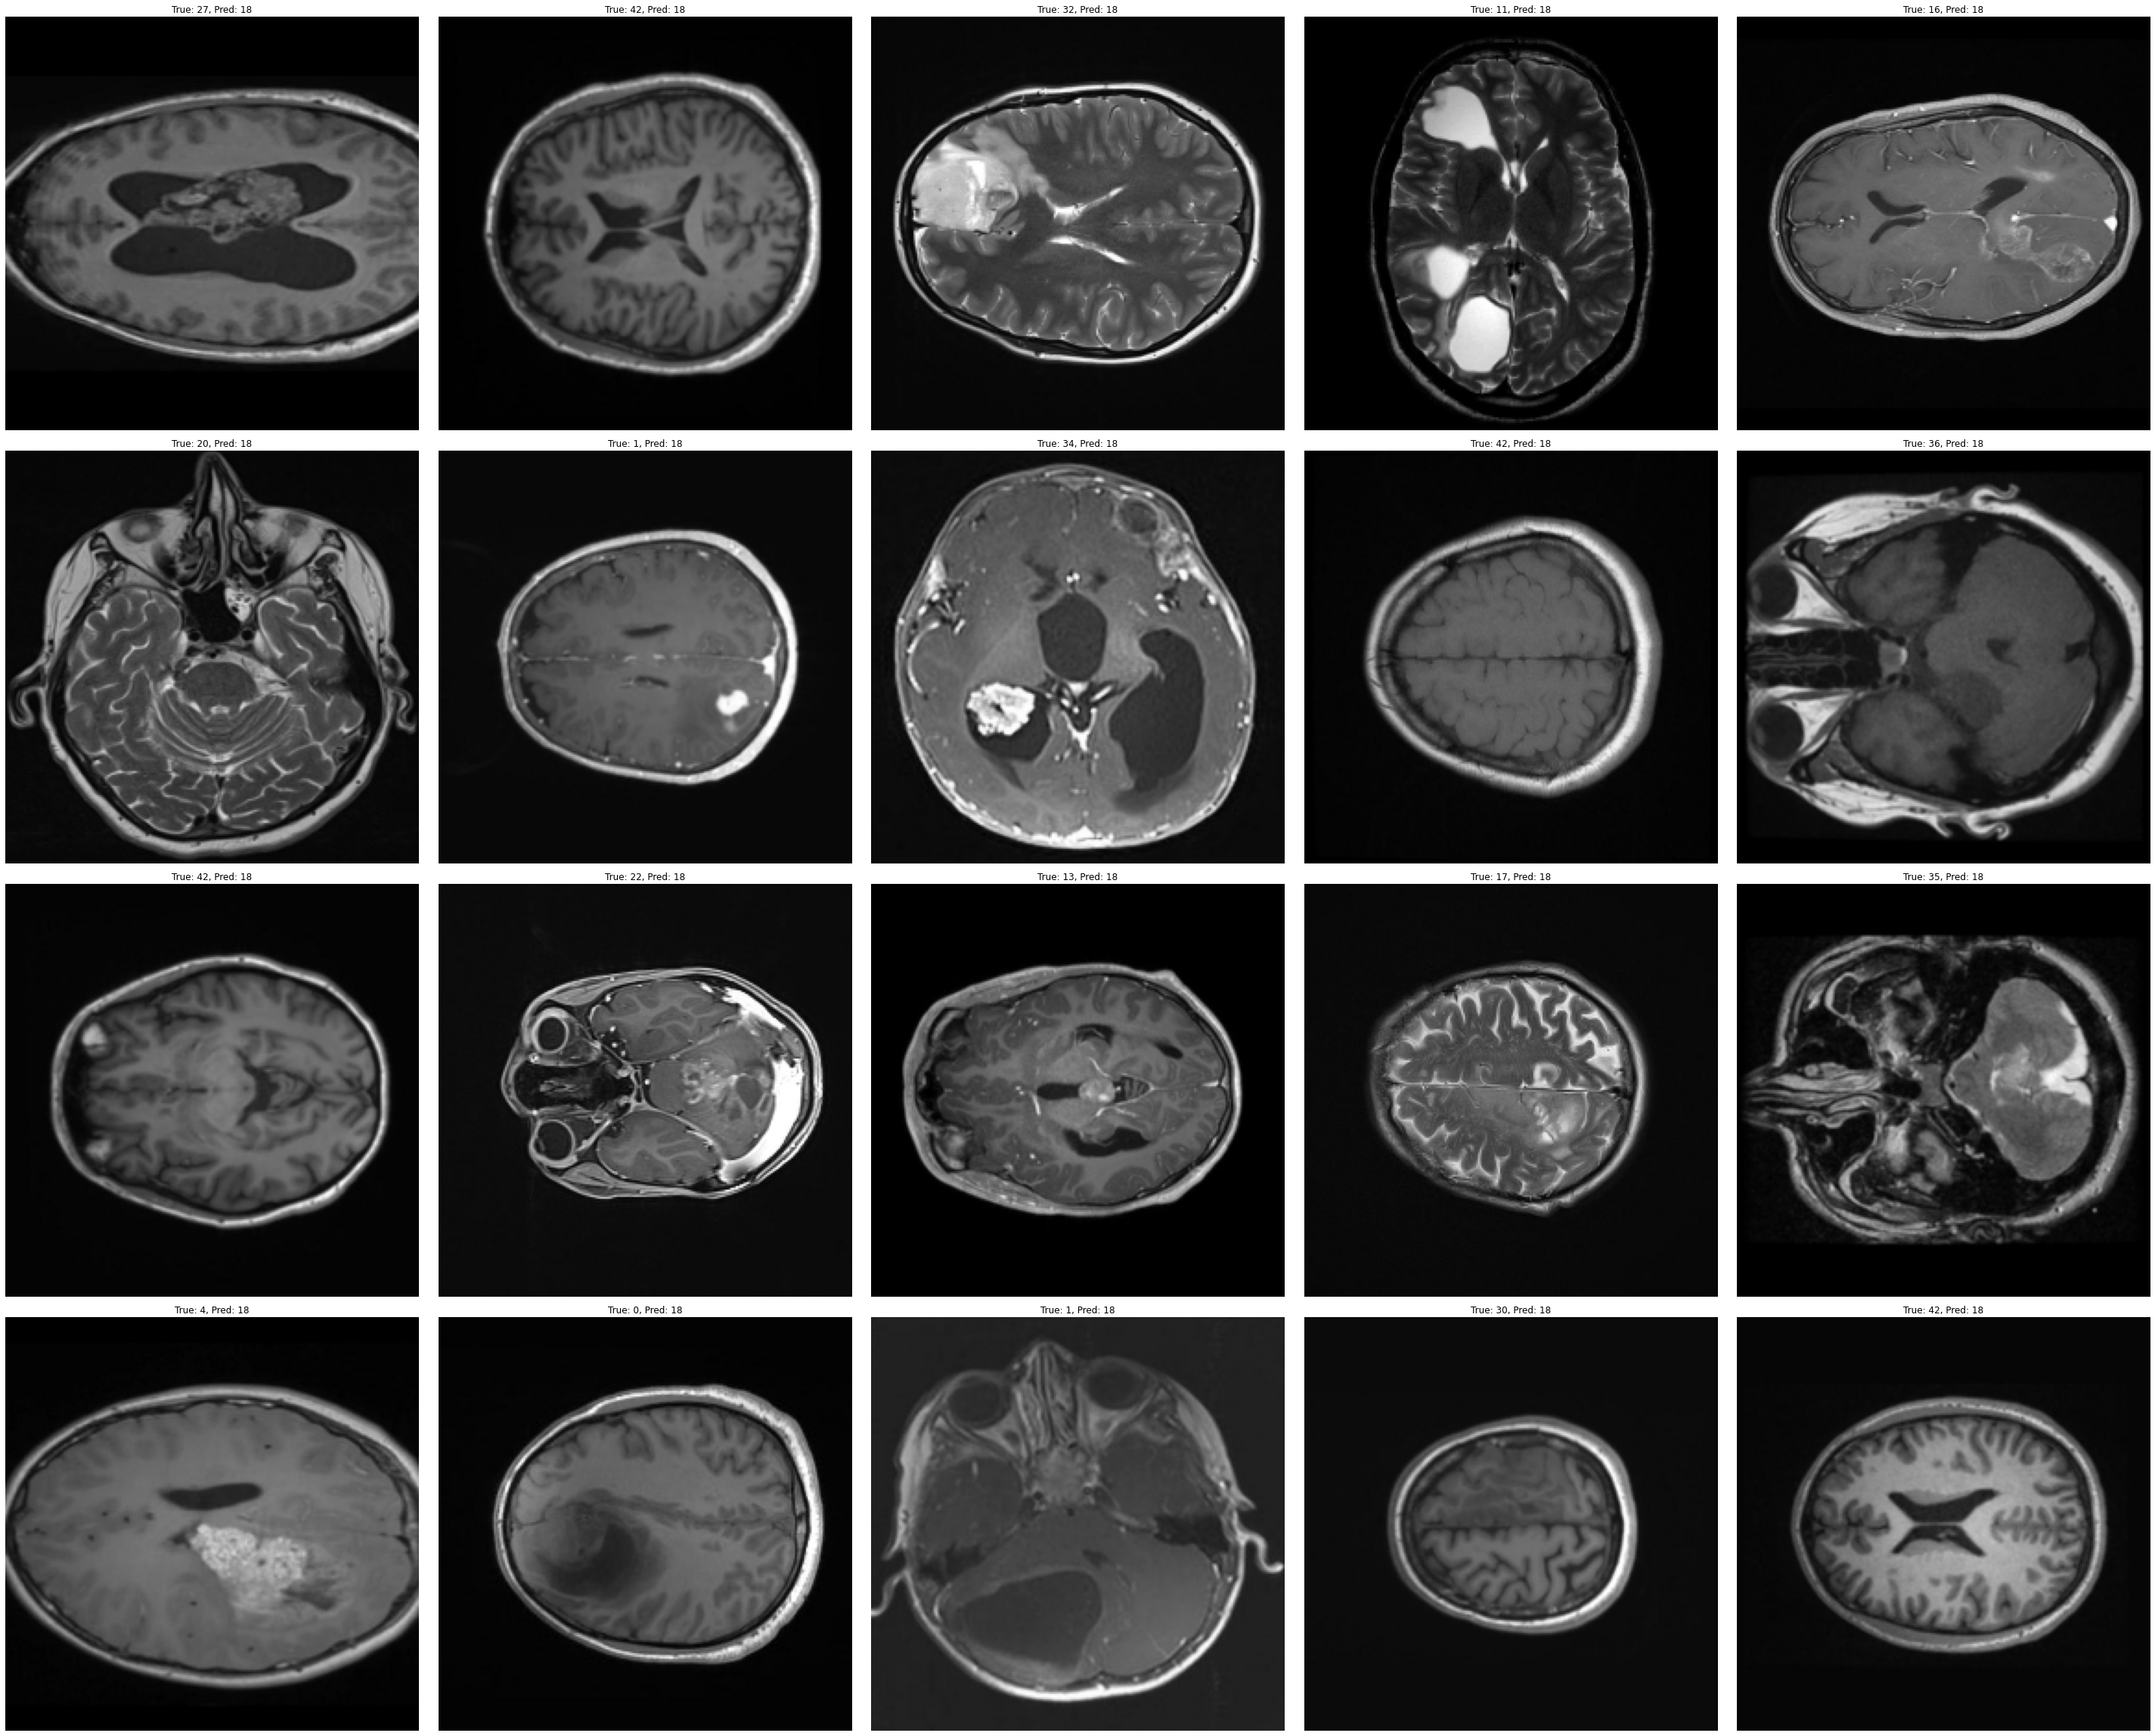

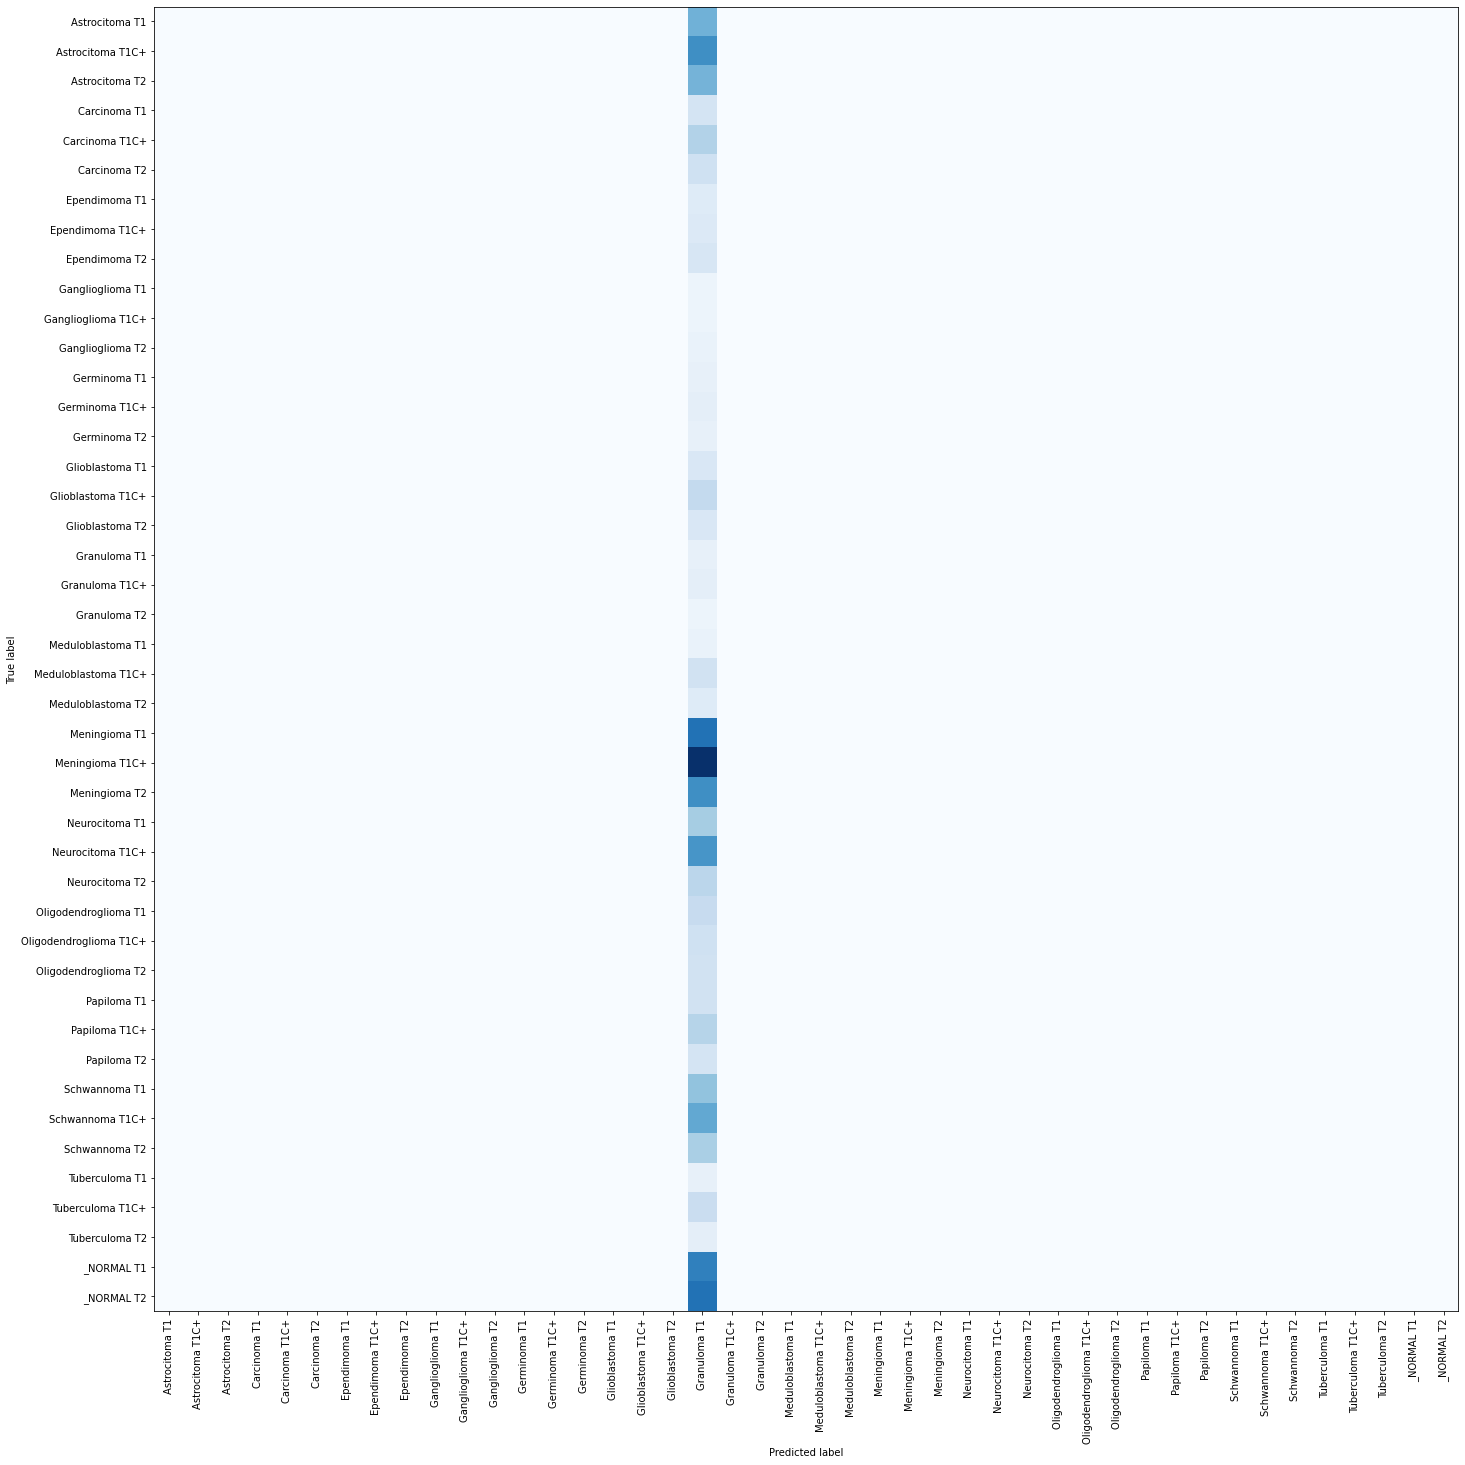

In [86]:
# Przygotowanie losowych przykładów ze zbioru testowego
num_examples = 20
random_indexes = np.random.choice(len(X_test), size=num_examples, replace=False)
X_examples = X_test[random_indexes]
y_true_examples = y_test[random_indexes]

# Predykcja klas dla losowych przykładów
y_pred_examples = model.predict(X_examples)

# Wizualizacja losowych przykładów wraz z prawdziwymi etykietami i predykcjami modelu
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(40, 32))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_examples[i])
    ax.axis('off')
    ax.set_title(f"True: {y_true_examples[i]}, Pred: {np.argmax(y_pred_examples[i])}")
plt.tight_layout()

# Macierz konfuzji dla zbioru testowego
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test_encoded, axis=1), y_pred)

# Wizualizacja macierzy konfuzji
fig, ax = plt.subplots(figsize=(32, 24))
ax.imshow(cm, cmap='Blues')

ax.set_xticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=90)
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(classes)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()


## Oversampling and poor results on test set

In [22]:
# Przekształcenie danych na format 2D - tablica z wymiarem próbek i cech
X_train_flat = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_flat, y_train)




In [23]:
X_resampled = X_resampled.reshape(-1, 224, 224, 3)

In [24]:
from collections import Counter

# Wyświetlenie liczby próbek w klasach przed oversamplingiem
print('Liczba próbek przed oversamplingiem:')
print(Counter(y_train))


# Wyświetlenie liczby próbek w klasach po oversamplingiem
print('\nLiczba próbek po oversamplingiem:')
print(Counter(y_resampled))


Liczba próbek przed oversamplingiem:
Counter({'25': 221, '24': 163, '43': 162, '42': 150, '1': 139, '26': 139, '28': 133, '37': 116, '0': 105, '2': 102, '36': 88, '27': 78, '38': 73, '4': 66, '34': 64, '29': 62, '16': 56, '30': 51, '40': 50, '5': 43, '31': 43, '22': 40, '3': 39, '32': 39, '33': 39, '35': 37, '8': 34, '15': 33, '17': 33, '7': 28, '6': 27, '23': 24, '13': 21, '41': 19, '18': 18, '19': 18, '12': 16, '14': 16, '39': 16, '11': 13, '21': 13, '9': 12, '10': 10, '20': 10})

Liczba próbek po oversamplingiem:
Counter({'0': 221, '1': 221, '2': 221, '3': 221, '4': 221, '5': 221, '6': 221, '7': 221, '8': 221, '9': 221, '10': 221, '11': 221, '12': 221, '13': 221, '14': 221, '15': 221, '16': 221, '17': 221, '18': 221, '19': 221, '20': 221, '21': 221, '22': 221, '23': 221, '24': 221, '25': 221, '26': 221, '27': 221, '28': 221, '29': 221, '30': 221, '31': 221, '32': 221, '33': 221, '34': 221, '35': 221, '36': 221, '37': 221, '38': 221, '39': 221, '40': 221, '41': 221, '42': 221, '43': 

## Model test after balance

In [41]:
#definition of architecture of model
model_balanced = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(44, activation='softmax')
])

#model compilation
model_balanced.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])

In [42]:
# Przekształcenie wektora klas do postaci one-hot encoding
y_resampled_encoded = to_categorical(y_resampled, num_classes=len(classes))
y_val_encoded = to_categorical(y_val, num_classes=len(classes))

# Trening
history = model_balanced.fit(X_resampled, y_resampled_encoded, epochs=15, batch_size=32,
                    validation_data=(X_val, y_val_encoded))


Epoch 1/15
304/304 [==============================] - ETA: 0s - loss: 5.8278 - accuracy: 0.3907 - precision_7: 0.7756 - recall_7: 0.2268 - f1_score: 0.3509

c:\Users\andrz\Anaconda3\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


304/304 [==============================] - 302s 988ms/step - loss: 5.8278 - accuracy: 0.3907 - precision_7: 0.7756 - recall_7: 0.2268 - f1_score: 0.3509 - val_loss: 2.2715 - val_accuracy: 0.4306 - val_precision_7: 0.7683 - val_recall_7: 0.2114 - val_f1_score: 0.3316
Epoch 2/15
304/304 [==============================] - 281s 924ms/step - loss: 0.8889 - accuracy: 0.7766 - precision_7: 0.8932 - recall_7: 0.6888 - f1_score: 0.7778 - val_loss: 1.5294 - val_accuracy: 0.6499 - val_precision_7: 0.7537 - val_recall_7: 0.5749 - val_f1_score: 0.6523
Epoch 3/15
304/304 [==============================] - 265s 871ms/step - loss: 0.3475 - accuracy: 0.9050 - precision_7: 0.9402 - recall_7: 0.8768 - f1_score: 0.9074 - val_loss: 1.4560 - val_accuracy: 0.7114 - val_precision_7: 0.7739 - val_recall_7: 0.6700 - val_f1_score: 0.7182
Epoch 4/15
304/304 [==============================] - 275s 904ms/step - loss: 0.1834 - accuracy: 0.9515 - precision_7: 0.9657 - recall_7: 0.9384 - f1_score: 0.9519 - val_loss: 1

KeyboardInterrupt: 

Overfitting observed

Regularization L2

In [44]:
model_balanced_l2 = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(44, activation='softmax')
])

In [45]:
#model compilation
model_balanced_l2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])

In [48]:
# Trening
history = model_balanced_l2.fit(X_resampled, y_resampled_encoded, epochs=15, batch_size=32,
                    validation_data=(X_val, y_val_encoded))

Epoch 1/15
304/304 [==============================] - 294s 966ms/step - loss: 3.0008 - accuracy: 0.8321 - precision_9: 0.9021 - recall_9: 0.7721 - f1_score: 0.8320 - val_loss: 3.6678 - val_accuracy: 0.6365 - val_precision_9: 0.7528 - val_recall_9: 0.5280 - val_f1_score: 0.6206
Epoch 2/15
304/304 [==============================] - 289s 950ms/step - loss: 2.4248 - accuracy: 0.8915 - precision_9: 0.9296 - recall_9: 0.8524 - f1_score: 0.8893 - val_loss: 3.5014 - val_accuracy: 0.6711 - val_precision_9: 0.7480 - val_recall_9: 0.6174 - val_f1_score: 0.6765
Epoch 3/15
304/304 [==============================] - 287s 944ms/step - loss: 2.1581 - accuracy: 0.9090 - precision_9: 0.9362 - recall_9: 0.8795 - f1_score: 0.9069 - val_loss: 3.4574 - val_accuracy: 0.6499 - val_precision_9: 0.7117 - val_recall_9: 0.6186 - val_f1_score: 0.6619
Epoch 4/15
304/304 [==============================] - 291s 958ms/step - loss: 2.1290 - accuracy: 0.9100 - precision_9: 0.9360 - recall_9: 0.8829 - f1_score: 0.9087 - 

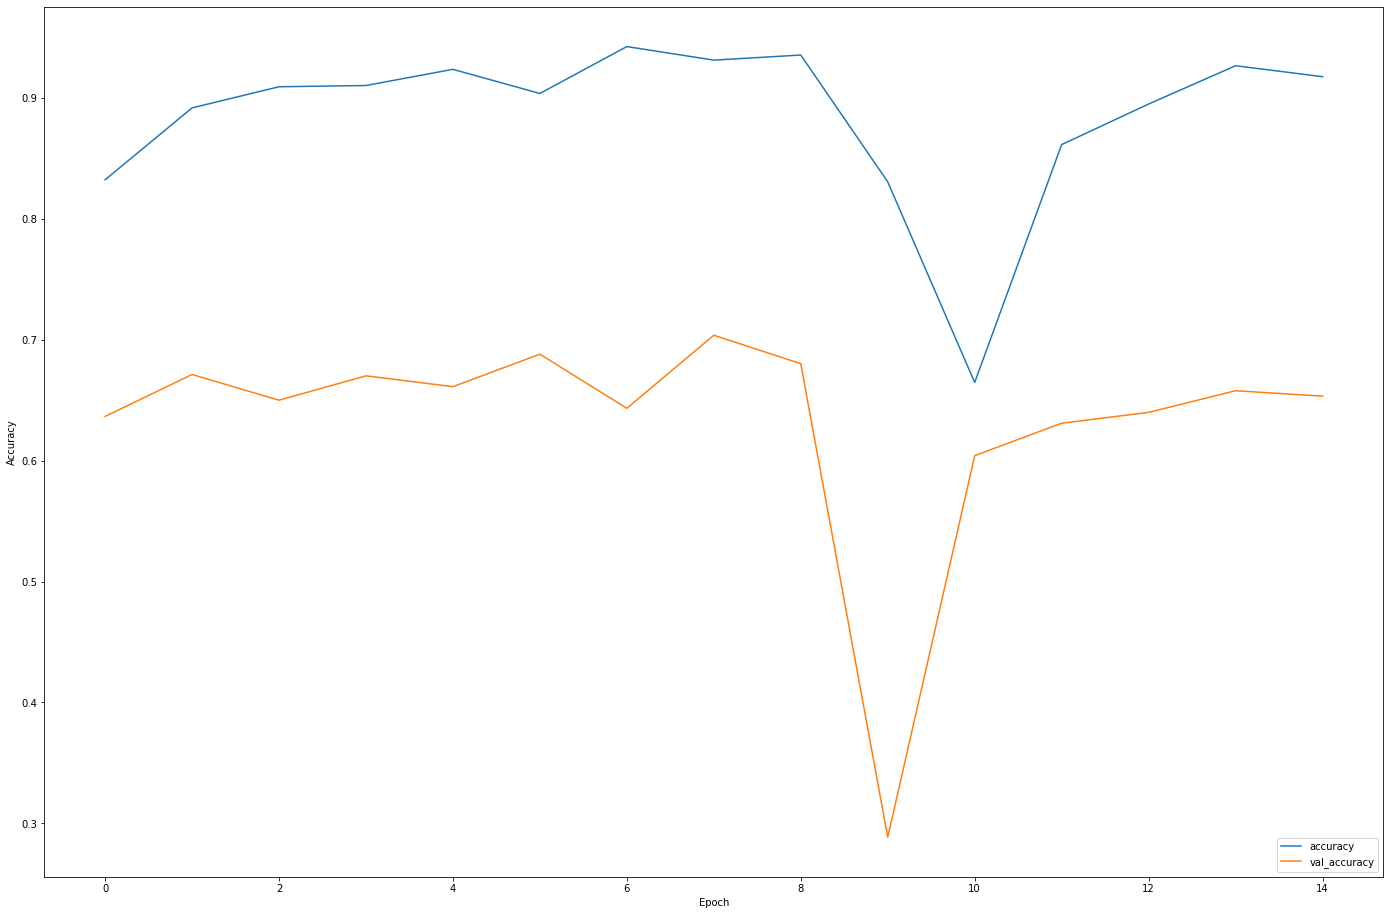

In [49]:
fig, ax = plt.subplots(figsize=(24, 16))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

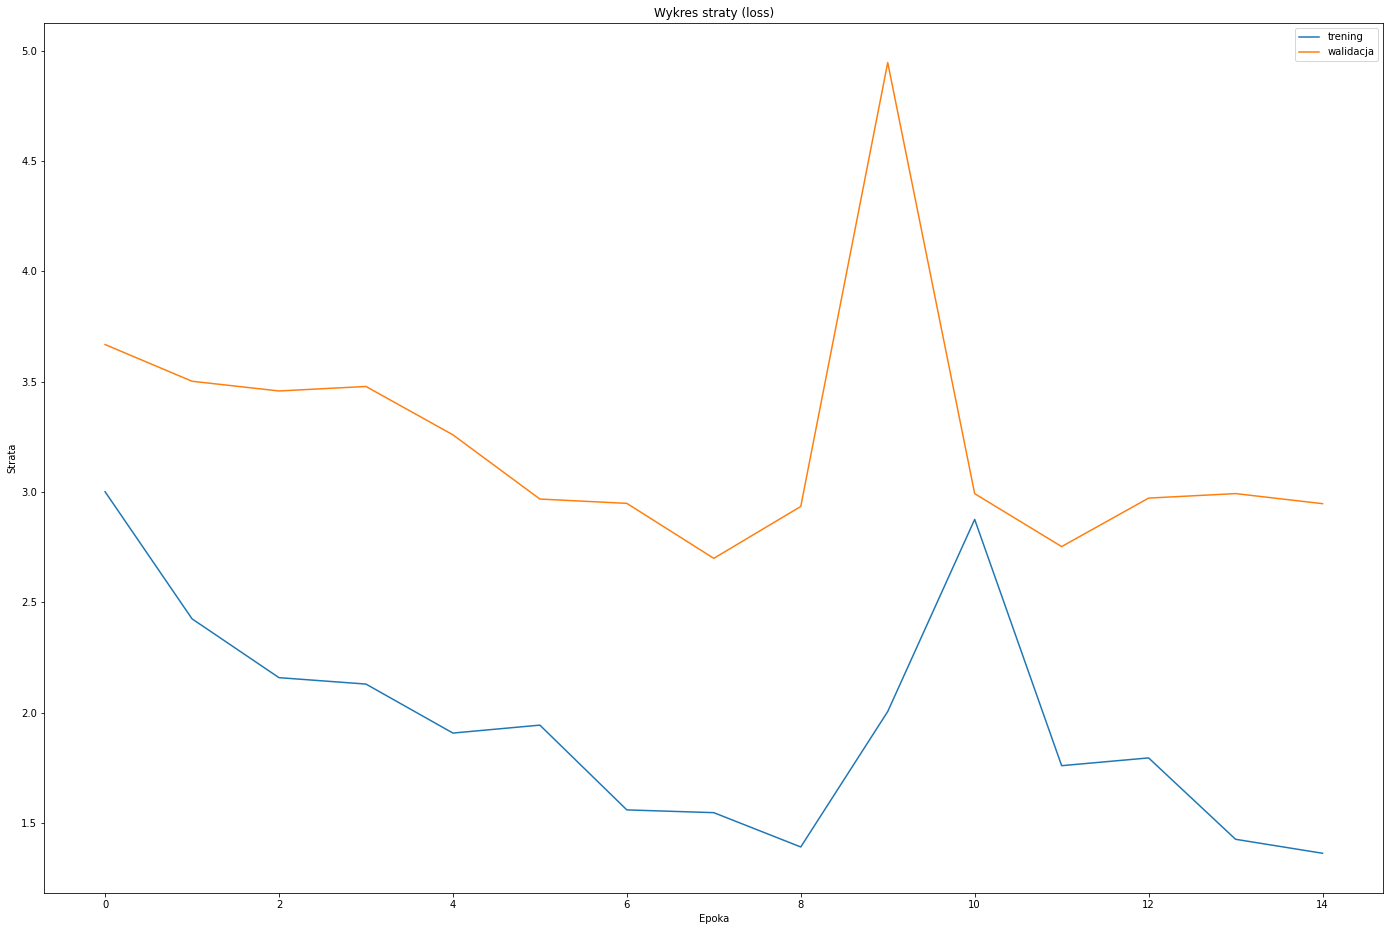

In [50]:
# rysowanie wykresu straty
fig, ax = plt.subplots(figsize=(24, 16))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Wykres straty (loss)')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(['trening', 'walidacja'], loc='upper right')
plt.show()

Let's make training longer - 30 epochs

In [52]:
# Trening
model_balanced_l2_30 = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(44, activation='softmax')
])

#model compilation
model_balanced_l2_30.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])

history = model_balanced_l2_30.fit(X_resampled, y_resampled_encoded, epochs=30, batch_size=32,
                    validation_data=(X_val, y_val_encoded))

Epoch 1/30
304/304 [==============================] - ETA: 0s - loss: 9.3219 - accuracy: 0.2853 - precision_11: 0.7387 - recall_11: 0.1361 - f1_score: 0.2298

c:\Users\andrz\Anaconda3\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


304/304 [==============================] - 266s 872ms/step - loss: 9.3219 - accuracy: 0.2853 - precision_11: 0.7387 - recall_11: 0.1361 - f1_score: 0.2298 - val_loss: 4.7866 - val_accuracy: 0.4799 - val_precision_11: 0.6816 - val_recall_11: 0.2897 - val_f1_score: 0.4066
Epoch 2/30
304/304 [==============================] - 257s 845ms/step - loss: 3.5506 - accuracy: 0.7232 - precision_11: 0.8682 - recall_11: 0.6031 - f1_score: 0.7118 - val_loss: 3.6106 - val_accuracy: 0.6622 - val_precision_11: 0.8031 - val_recall_11: 0.5749 - val_f1_score: 0.6701
Epoch 3/30
304/304 [==============================] - 250s 821ms/step - loss: 2.5988 - accuracy: 0.8572 - precision_11: 0.9156 - recall_11: 0.8094 - f1_score: 0.8592 - val_loss: 3.3461 - val_accuracy: 0.6879 - val_precision_11: 0.7639 - val_recall_11: 0.6152 - val_f1_score: 0.6815
Epoch 4/30
304/304 [==============================] - 265s 874ms/step - loss: 2.1386 - accuracy: 0.9009 - precision_11: 0.9293 - recall_11: 0.8700 - f1_score: 0.8987

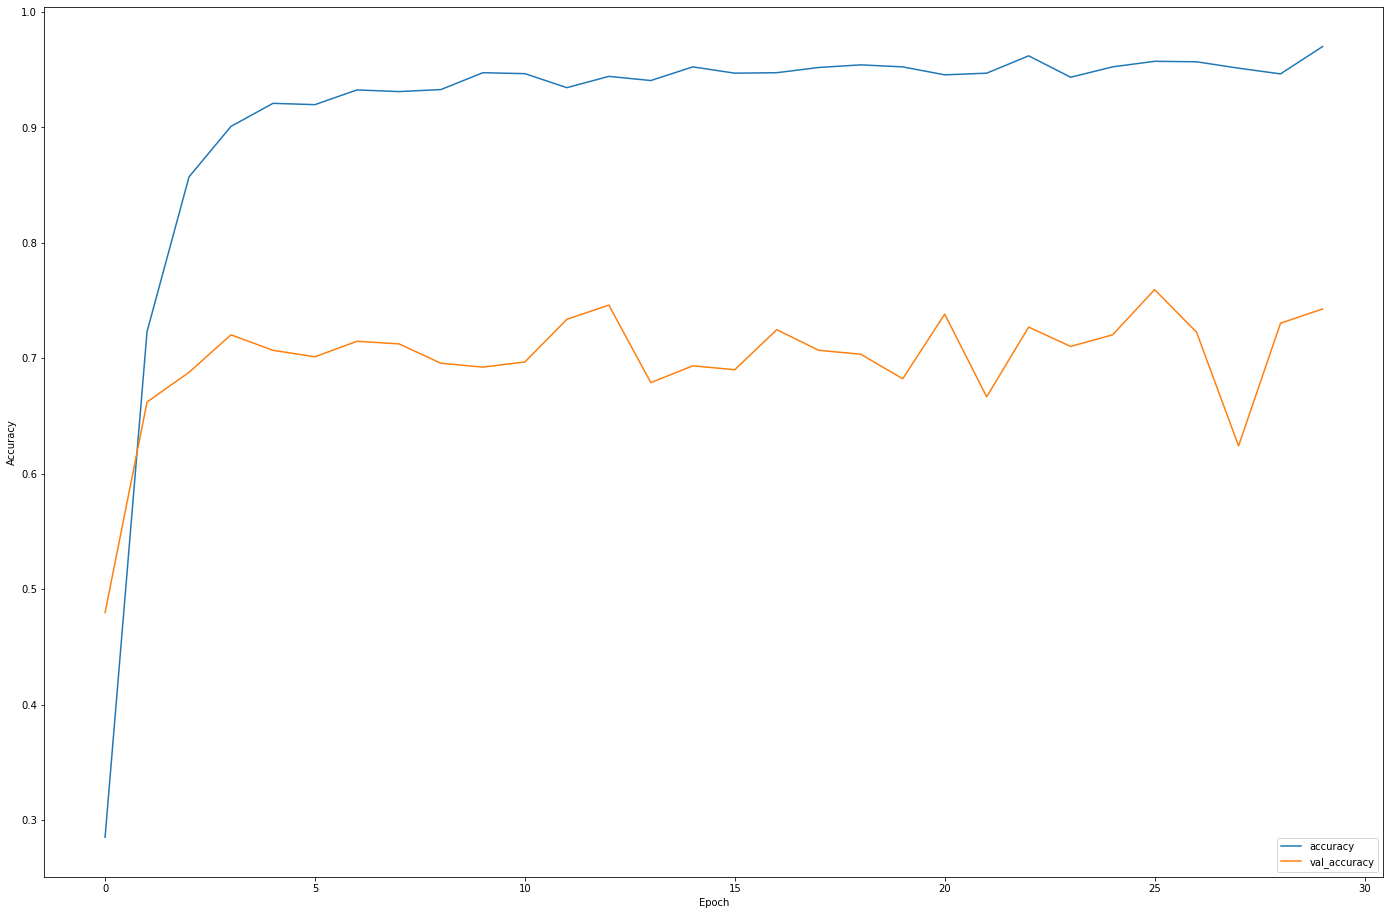

In [53]:
fig, ax = plt.subplots(figsize=(24, 16))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

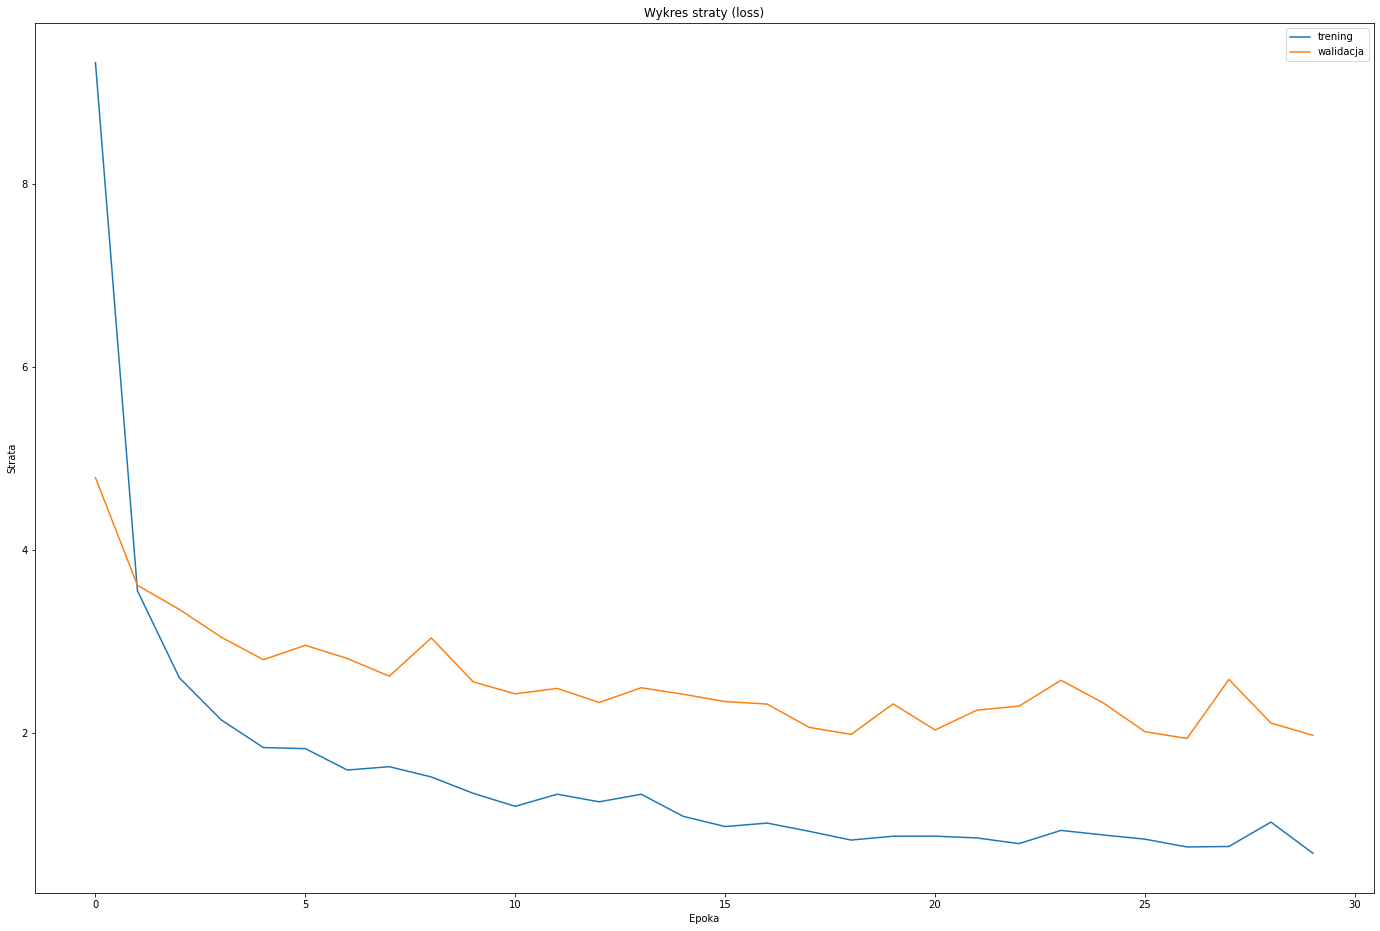

In [54]:
# rysowanie wykresu straty
fig, ax = plt.subplots(figsize=(24, 16))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Wykres straty (loss)')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(['trening', 'walidacja'], loc='upper right')
plt.show()

In [61]:
# zakoduj etykiety w zbiorze testowym
y_test_encoded = to_categorical(y_test, num_classes=44)

In [63]:
test_loss, test_acc, test_precision, test_recall, test_f1_score = model_balanced_l2_30.evaluate(X_test, y_test_encoded)

c:\Users\andrz\Anaconda3\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


29/29 [==============================] - 7s 237ms/step - loss: 1.9849 - accuracy: 0.7325 - precision_11: 0.7690 - recall_11: 0.7083 - f1_score: 0.7374


In [66]:
# Uzyskanie predykcji dla zbioru testowego
y_pred = model_balanced_l2_30.predict(X_test)

# Konwersja predykcji i rzeczywistych etykiet na wartości binarne
y_pred_binary = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test_encoded, axis=1)

# Wyświetlenie raportu klasyfikacji
print(classification_report(y_test_binary, y_pred_binary))


              precision    recall  f1-score   support

           0       0.56      0.75      0.64        36
           1       0.71      0.64      0.67        47
           2       0.68      0.43      0.53        35
           3       0.73      0.85      0.79        13
           4       1.00      0.83      0.90        23
           5       0.93      0.93      0.93        15
           6       1.00      0.56      0.71         9
           7       0.29      0.60      0.39        10
           8       1.00      0.50      0.67        12
           9       0.40      0.50      0.44         4
          10       0.00      0.00      0.00         4
          11       0.40      0.40      0.40         5
          12       1.00      0.67      0.80         6
          13       0.50      0.86      0.63         7
          14       0.80      0.67      0.73         6
          15       0.83      0.91      0.87        11
          16       0.79      1.00      0.88        19
          17       0.44    

Looks, that there is still chance to learn - check on 50 epochs now

In [87]:
# Trening
model_balanced_l2_50 = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(44, activation='softmax')
])

#model compilation
model_balanced_l2_50.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])

history = model_balanced_l2_50.fit(X_resampled, y_resampled_encoded, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val_encoded))

Epoch 1/50
304/304 [==============================] - ETA: 0s - loss: 13.0288 - accuracy: 0.3792 - precision_13: 0.7734 - recall_13: 0.2060 - f1_score: 0.3253

c:\Users\andrz\Anaconda3\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


304/304 [==============================] - 291s 955ms/step - loss: 13.0288 - accuracy: 0.3792 - precision_13: 0.7734 - recall_13: 0.2060 - f1_score: 0.3253 - val_loss: 4.9284 - val_accuracy: 0.4597 - val_precision_13: 0.6556 - val_recall_13: 0.2662 - val_f1_score: 0.3787
Epoch 2/50
304/304 [==============================] - 274s 900ms/step - loss: 3.5868 - accuracy: 0.7466 - precision_13: 0.8758 - recall_13: 0.6439 - f1_score: 0.7421 - val_loss: 3.9288 - val_accuracy: 0.6477 - val_precision_13: 0.7844 - val_recall_13: 0.5168 - val_f1_score: 0.6231
Epoch 3/50
304/304 [==============================] - 267s 878ms/step - loss: 2.7682 - accuracy: 0.8610 - precision_13: 0.9149 - recall_13: 0.8090 - f1_score: 0.8587 - val_loss: 3.5330 - val_accuracy: 0.6588 - val_precision_13: 0.7622 - val_recall_13: 0.5593 - val_f1_score: 0.6452
Epoch 4/50
304/304 [==============================] - 286s 941ms/step - loss: 2.4181 - accuracy: 0.8898 - precision_13: 0.9257 - recall_13: 0.8538 - f1_score: 0.888

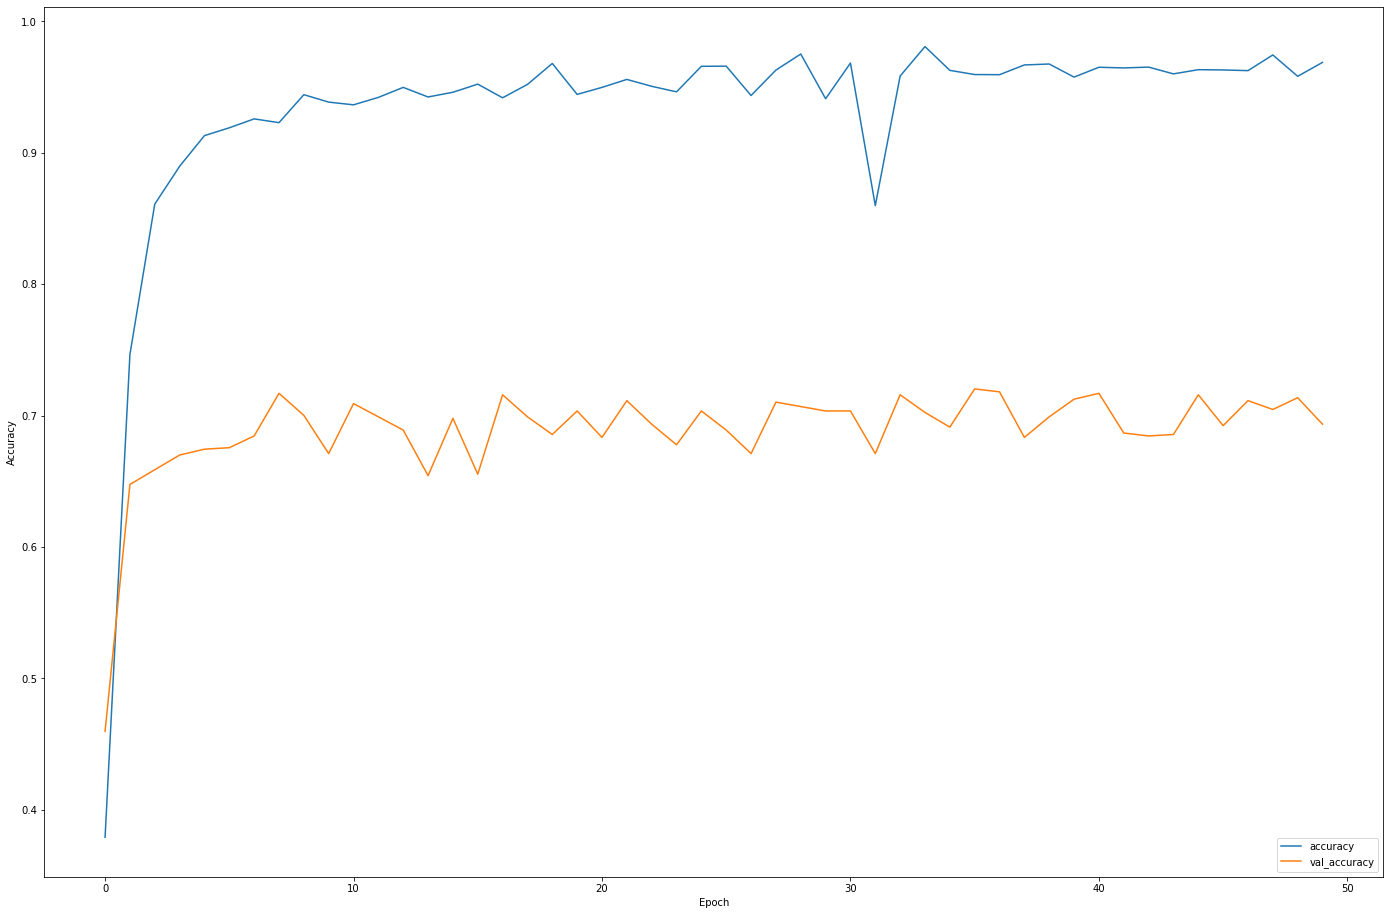

In [88]:
fig, ax = plt.subplots(figsize=(24, 16))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

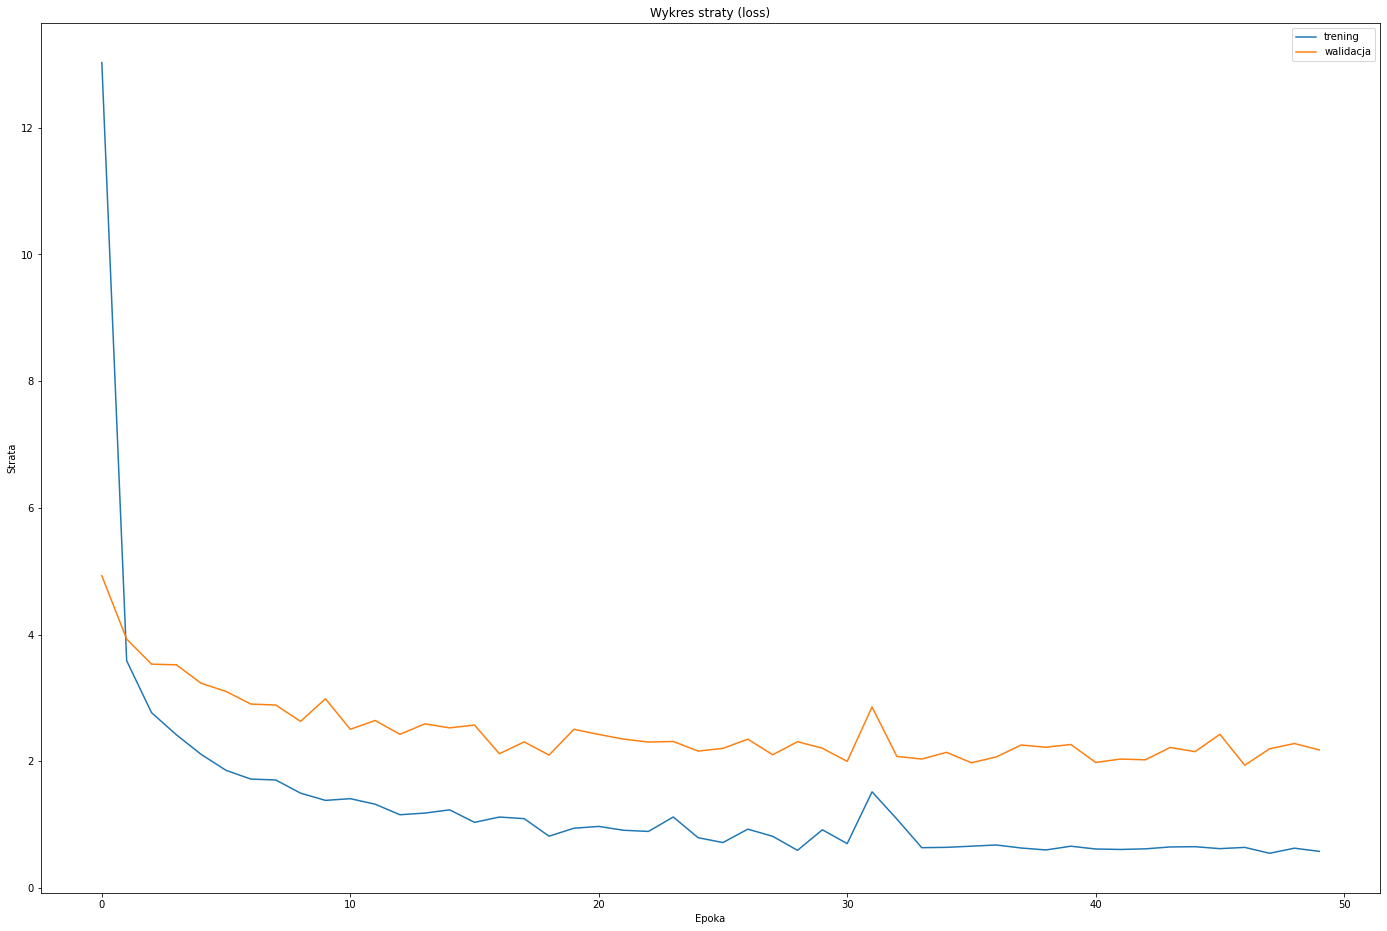

In [89]:
# rysowanie wykresu straty
fig, ax = plt.subplots(figsize=(24, 16))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Wykres straty (loss)')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(['trening', 'walidacja'], loc='upper right')
plt.show()

In [90]:
test_loss, test_acc, test_precision, test_recall, test_f1_score = model_balanced_l2_50.evaluate(X_test, y_test_encoded)

29/29 [==============================] - 10s 339ms/step - loss: 2.3171 - accuracy: 0.6579 - precision_13: 0.7054 - recall_13: 0.6327 - f1_score: 0.6671


In [91]:
# Uzyskanie predykcji dla zbioru testowego
y_pred = model_balanced_l2_50.predict(X_test)

# Konwersja predykcji i rzeczywistych etykiet na wartości binarne
y_pred_binary = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test_encoded, axis=1)

# Wyświetlenie raportu klasyfikacji
print(classification_report(y_test_binary, y_pred_binary))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63        36
           1       0.74      0.55      0.63        47
           2       0.42      0.60      0.49        35
           3       0.85      0.85      0.85        13
           4       0.91      0.87      0.89        23
           5       0.71      1.00      0.83        15
           6       0.67      0.67      0.67         9
           7       0.60      0.60      0.60        10
           8       0.50      0.42      0.45        12
           9       0.67      0.50      0.57         4
          10       0.00      0.00      0.00         4
          11       0.44      0.80      0.57         5
          12       0.45      0.83      0.59         6
          13       0.36      0.57      0.44         7
          14       0.56      0.83      0.67         6
          15       0.71      0.91      0.80        11
          16       0.56      0.95      0.71        19
          17       0.19    

c:\Users\andrz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andrz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andrz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


30 epochs, regularization x 2

In [92]:
# Trening
model_balanced_l2_2_30 = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.Dense(44, activation='softmax')
])

#model compilation
model_balanced_l2_2_30.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])

history = model_balanced_l2_2_30.fit(X_resampled, y_resampled_encoded, epochs=30, batch_size=32,
                    validation_data=(X_val, y_val_encoded))

Epoch 1/30
304/304 [==============================] - ETA: 0s - loss: 12.7940 - accuracy: 0.3707 - precision_15: 0.7562 - recall_15: 0.2026 - f1_score: 0.3196

c:\Users\andrz\Anaconda3\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


304/304 [==============================] - 280s 911ms/step - loss: 12.7940 - accuracy: 0.3707 - precision_15: 0.7562 - recall_15: 0.2026 - f1_score: 0.3196 - val_loss: 6.2778 - val_accuracy: 0.4642 - val_precision_15: 0.7553 - val_recall_15: 0.2383 - val_f1_score: 0.3622
Epoch 2/30
304/304 [==============================] - 273s 896ms/step - loss: 4.8105 - accuracy: 0.7219 - precision_15: 0.8683 - recall_15: 0.6012 - f1_score: 0.7105 - val_loss: 5.1007 - val_accuracy: 0.6152 - val_precision_15: 0.7607 - val_recall_15: 0.4978 - val_f1_score: 0.6018
Epoch 3/30
304/304 [==============================] - 266s 875ms/step - loss: 3.6013 - accuracy: 0.8366 - precision_15: 0.9040 - recall_15: 0.7719 - f1_score: 0.8328 - val_loss: 4.5483 - val_accuracy: 0.5604 - val_precision_15: 0.7422 - val_recall_15: 0.3993 - val_f1_score: 0.5193
Epoch 4/30
304/304 [==============================] - 260s 854ms/step - loss: 3.3756 - accuracy: 0.8468 - precision_15: 0.9058 - recall_15: 0.7901 - f1_score: 0.844

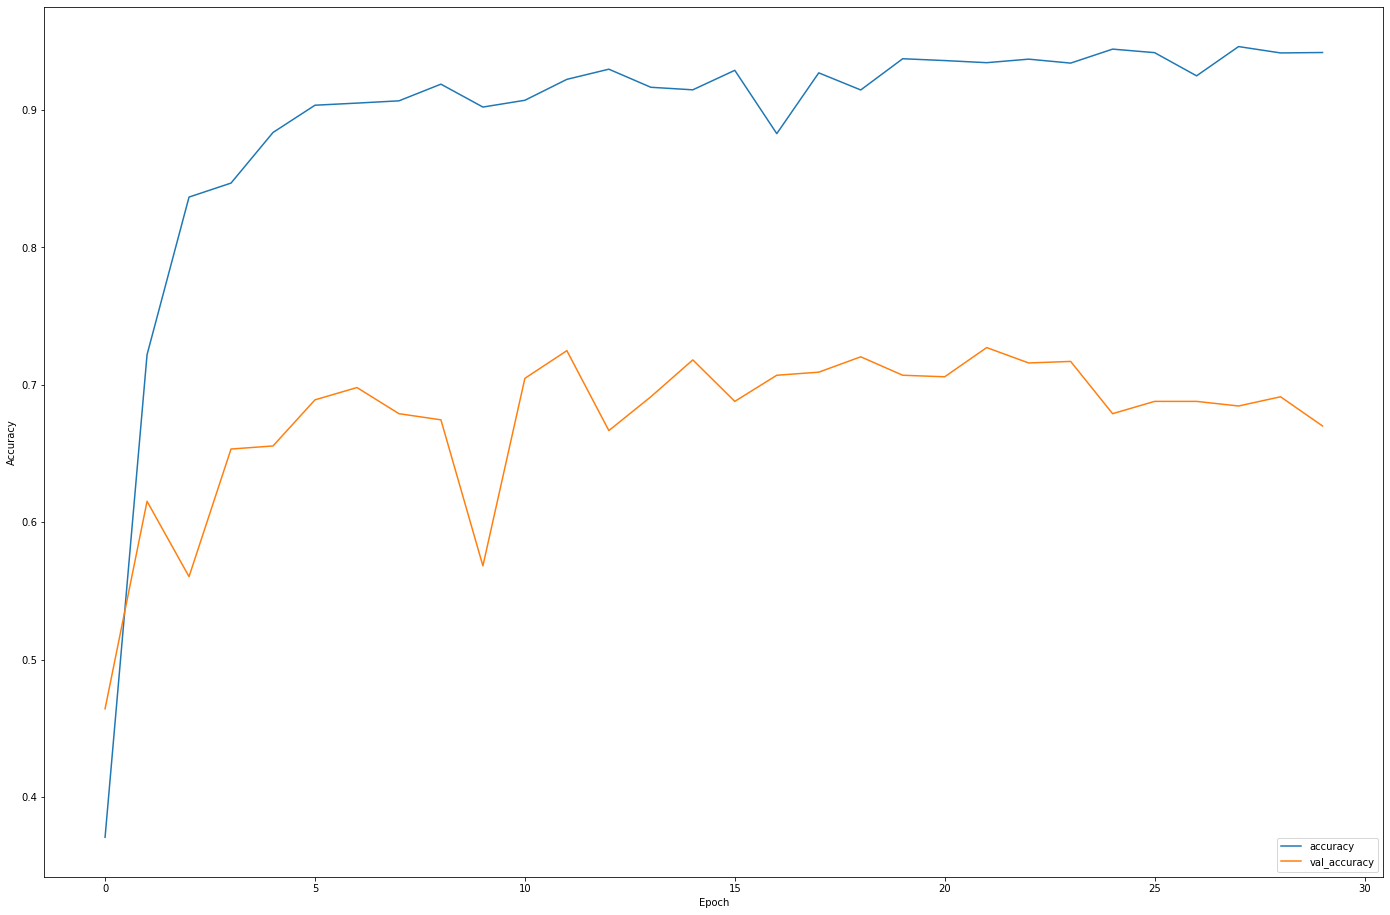

In [93]:
fig, ax = plt.subplots(figsize=(24, 16))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

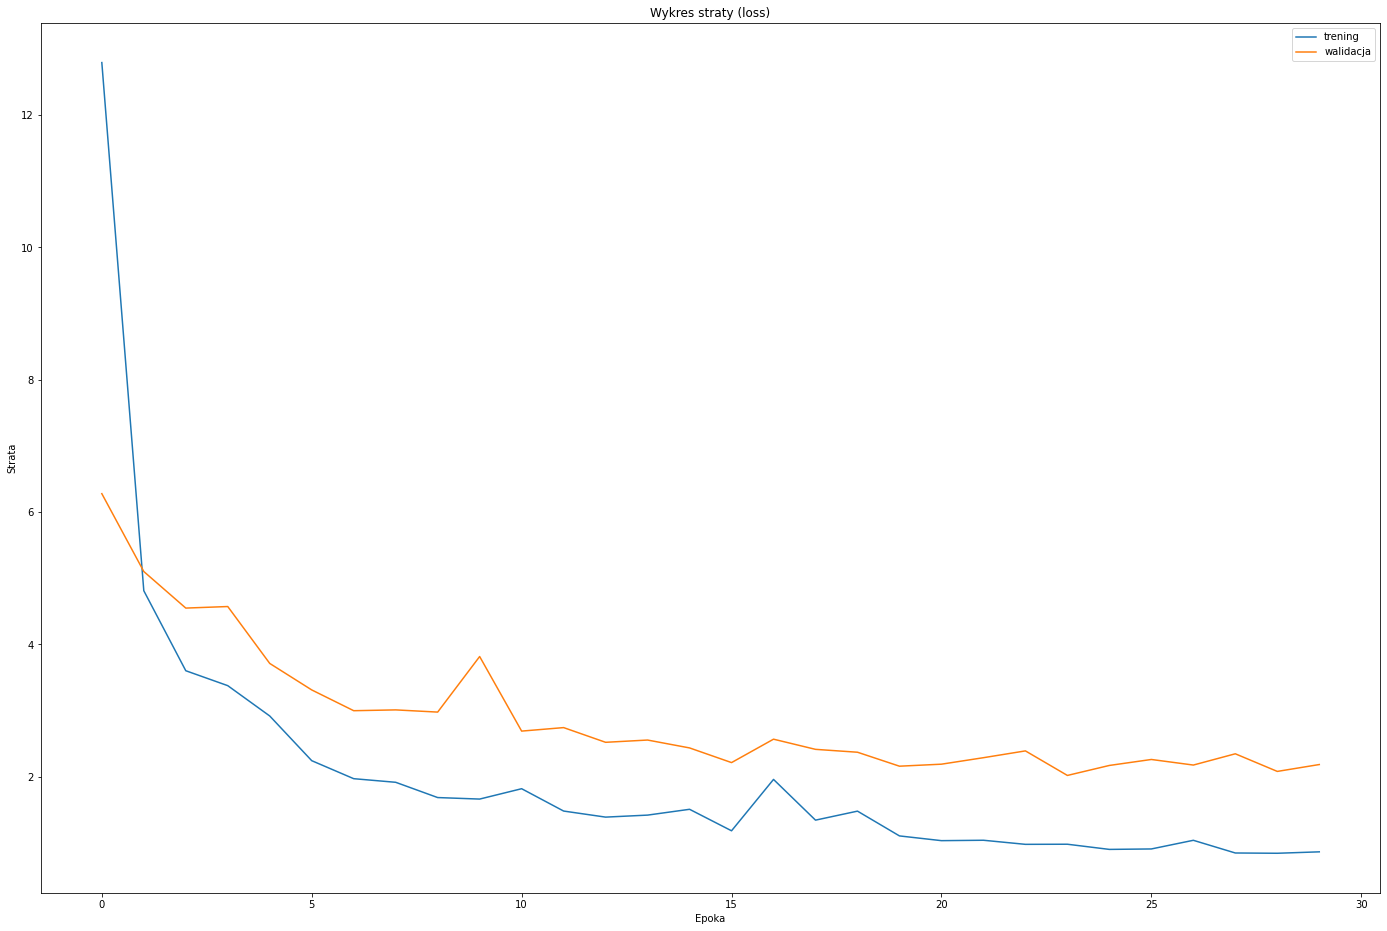

In [94]:
# rysowanie wykresu straty
fig, ax = plt.subplots(figsize=(24, 16))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Wykres straty (loss)')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(['trening', 'walidacja'], loc='upper right')
plt.show()

In [97]:
# Trening
model_balanced_l2_2_30_bs48 = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.Dense(44, activation='softmax')
])

#model compilation
model_balanced_l2_2_30_bs48.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])

history = model_balanced_l2_2_30_bs48.fit(X_resampled, y_resampled_encoded, epochs=30, batch_size=48,
                    validation_data=(X_val, y_val_encoded))

Epoch 1/30
203/203 [==============================] - ETA: 0s - loss: 21.4174 - accuracy: 0.3988 - precision_21: 0.7393 - recall_21: 0.2418 - f1_score: 0.3644

c:\Users\andrz\Anaconda3\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


203/203 [==============================] - 271s 1s/step - loss: 21.4174 - accuracy: 0.3988 - precision_21: 0.7393 - recall_21: 0.2418 - f1_score: 0.3644 - val_loss: 7.2386 - val_accuracy: 0.5414 - val_precision_21: 0.7759 - val_recall_21: 0.3602 - val_f1_score: 0.4920
Epoch 2/30
203/203 [==============================] - 257s 1s/step - loss: 5.6175 - accuracy: 0.7987 - precision_21: 0.8897 - recall_21: 0.7191 - f1_score: 0.7954 - val_loss: 5.7273 - val_accuracy: 0.6890 - val_precision_21: 0.7757 - val_recall_21: 0.6152 - val_f1_score: 0.6862
Epoch 3/30
203/203 [==============================] - 252s 1s/step - loss: 4.3927 - accuracy: 0.8810 - precision_21: 0.9294 - recall_21: 0.8389 - f1_score: 0.8818 - val_loss: 5.0979 - val_accuracy: 0.6857 - val_precision_21: 0.7870 - val_recall_21: 0.6074 - val_f1_score: 0.6856
Epoch 4/30
203/203 [==============================] - 254s 1s/step - loss: 3.7087 - accuracy: 0.9069 - precision_21: 0.9385 - recall_21: 0.8748 - f1_score: 0.9056 - val_loss

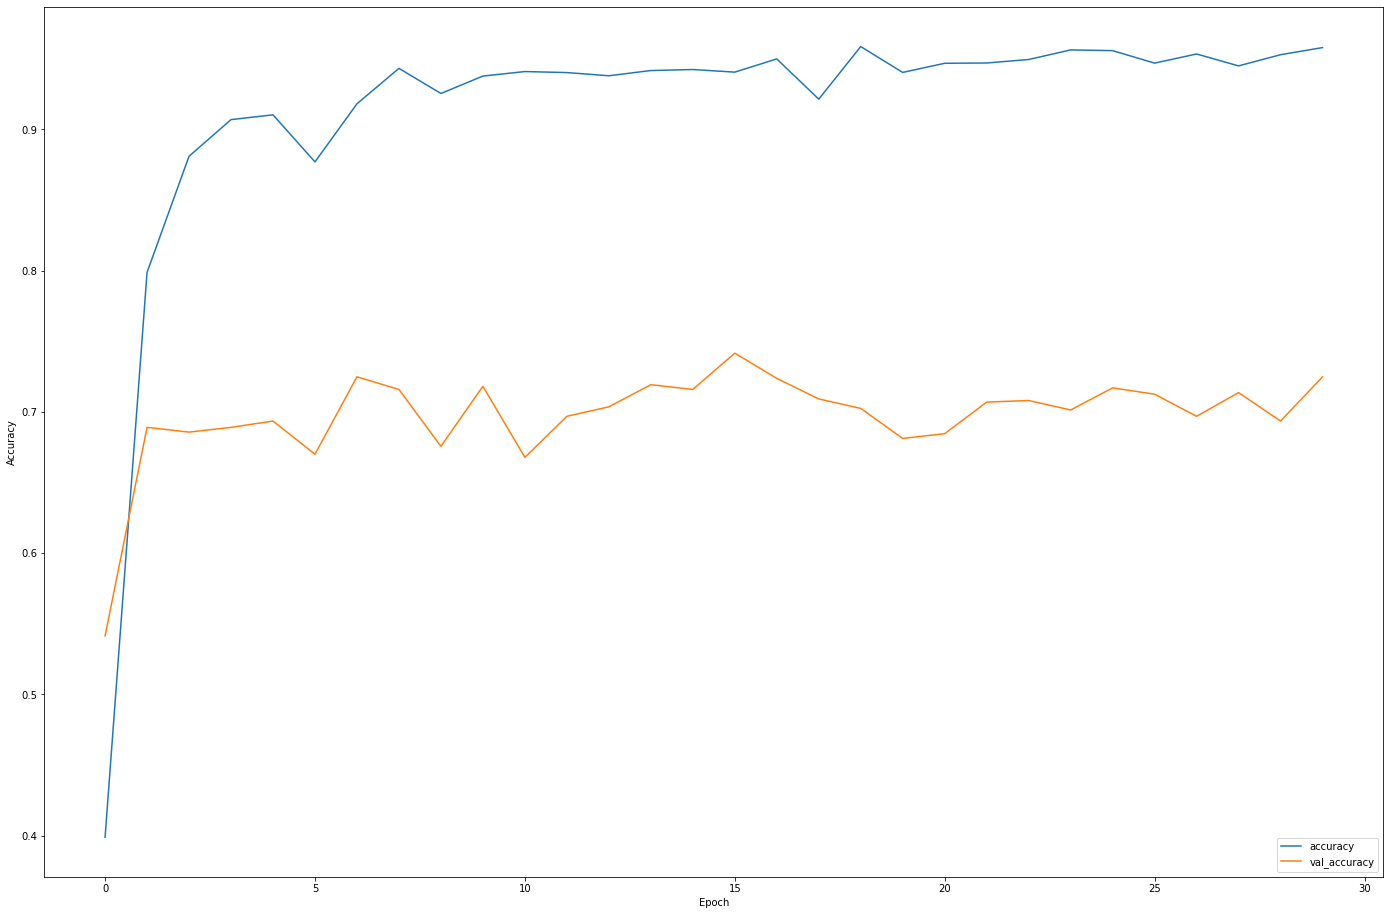

In [98]:
fig, ax = plt.subplots(figsize=(24, 16))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

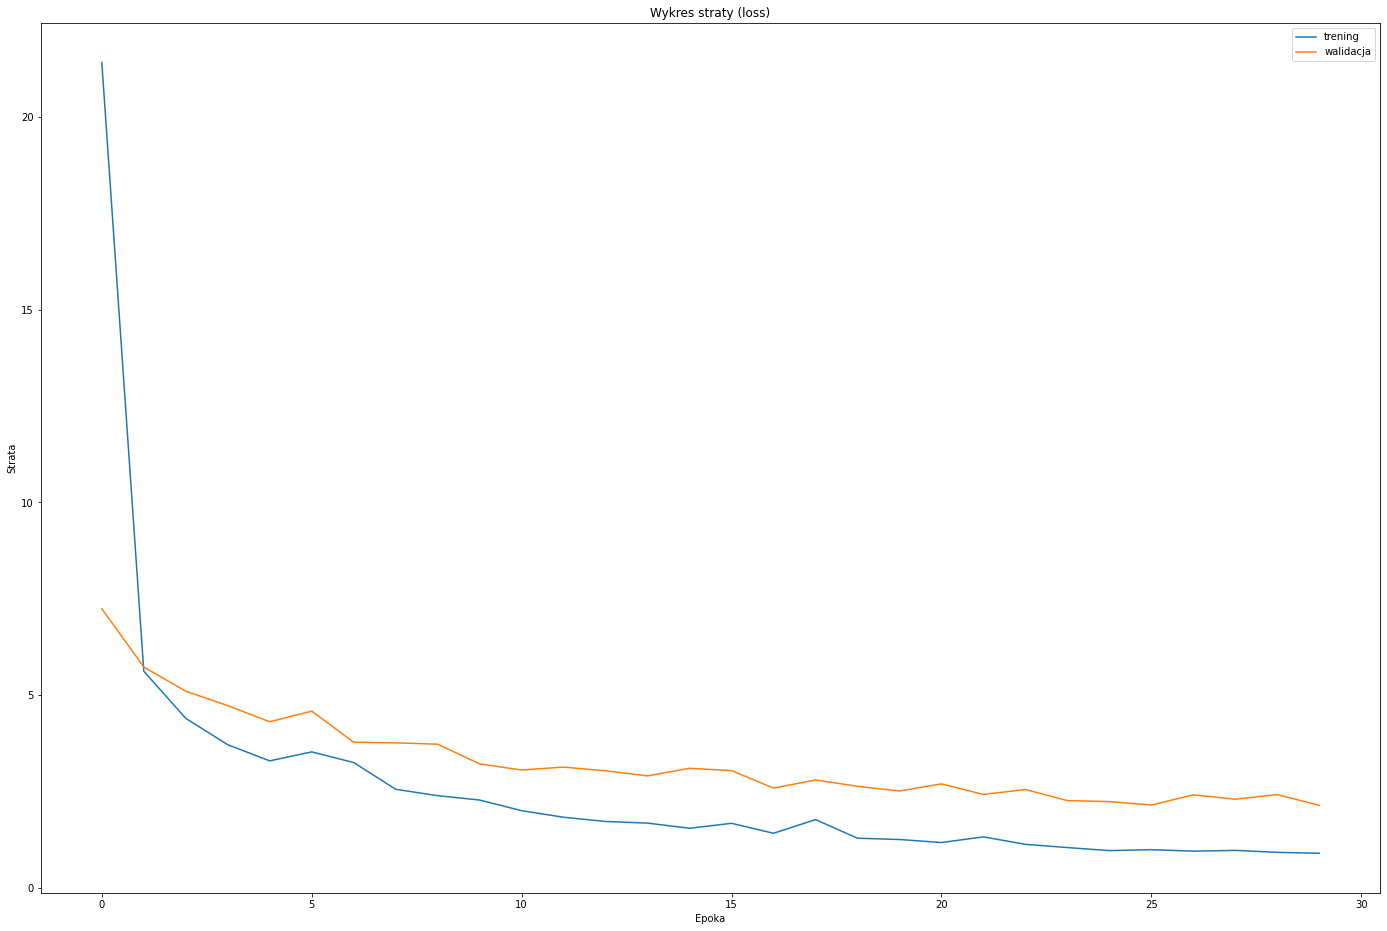

In [99]:
# rysowanie wykresu straty
fig, ax = plt.subplots(figsize=(24, 16))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Wykres straty (loss)')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(['trening', 'walidacja'], loc='upper right')
plt.show()

In [101]:
test_loss, test_acc, test_precision, test_recall, test_f1_score = model_balanced_l2_2_30_bs48.evaluate(X_test, y_test_encoded)

c:\Users\andrz\Anaconda3\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


29/29 [==============================] - 6s 206ms/step - loss: 2.1897 - accuracy: 0.7346 - precision_21: 0.7666 - recall_21: 0.7204 - f1_score: 0.7428


In [100]:
# Uzyskanie predykcji dla zbioru testowego
y_pred = model_balanced_l2_2_30_bs48.predict(X_test)

# Konwersja predykcji i rzeczywistych etykiet na wartości binarne
y_pred_binary = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test_encoded, axis=1)

# Wyświetlenie raportu klasyfikacji
print(classification_report(y_test_binary, y_pred_binary))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66        36
           1       0.64      0.72      0.68        47
           2       0.55      0.80      0.65        35
           3       1.00      0.85      0.92        13
           4       0.81      0.91      0.86        23
           5       0.87      0.87      0.87        15
           6       0.67      0.67      0.67         9
           7       0.67      0.40      0.50        10
           8       0.86      0.50      0.63        12
           9       0.33      0.50      0.40         4
          10       0.00      0.00      0.00         4
          11       1.00      0.40      0.57         5
          12       0.67      0.67      0.67         6
          13       0.50      0.71      0.59         7
          14       0.60      1.00      0.75         6
          15       0.77      0.91      0.83        11
          16       0.77      0.89      0.83        19
          17       0.00    

c:\Users\andrz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andrz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andrz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
# odwrócenie słownika
reversed_class_dict = {v: k for k, v in class_dict.items()}

# lista wartości, dla których chcemy wyszukać klucze
values = [9,10,11,13,17, 20, 21, 26,35,41]

# lista kluczy
poor_classes = []

# wyszukiwanie kluczy dla każdej wartości z listy
for value in values:
    key = reversed_class_dict.get(value)
    poor_classes.append(key)

print(poor_classes)


['Ganglioglioma T1', 'Ganglioglioma T1C+', 'Ganglioglioma T2', 'Germinoma T1C+', 'Glioblastoma T2', 'Granuloma T2', 'Meduloblastoma T1', 'Meningioma T2', 'Papiloma T2', 'Tuberculoma T2']


Augmentation for poor classes

In [134]:
datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   brightness_range=[0.7, 1.3], # zmiana jasności w zakresie 0.7-1.3
                                   zoom_range=[0.9, 1.1], # przybliżenie lub oddalenie obrazu
                                   fill_mode='nearest')

train_generator = datagen.flow_from_directory(train_path,
                                                    target_size=(224, 224),
                                                    batch_size=48,
                                                    class_mode='categorical',
                                                    classes=poor_classes)


validation_generator = datagen.flow_from_directory(os.path.join(validation_path),
                                                              target_size=(224, 224),
                                                              batch_size=48,
                                                              class_mode='categorical',
                                                              classes=poor_classes)


Found 307 images belonging to 10 classes.
Found 106 images belonging to 10 classes.


In [154]:
# Wyświetlenie liczby próbek w klasach po oversamplingiem
print('\nLiczba próbek po oversamplingiem:')
print(Counter(y_resampled))


Liczba próbek po oversamplingiem:
Counter({'0': 221, '1': 221, '2': 221, '3': 221, '4': 221, '5': 221, '6': 221, '7': 221, '8': 221, '9': 221, '10': 221, '11': 221, '12': 221, '13': 221, '14': 221, '15': 221, '16': 221, '17': 221, '18': 221, '19': 221, '20': 221, '21': 221, '22': 221, '23': 221, '24': 221, '25': 221, '26': 221, '27': 221, '28': 221, '29': 221, '30': 221, '31': 221, '32': 221, '33': 221, '34': 221, '35': 221, '36': 221, '37': 221, '38': 221, '39': 221, '40': 221, '41': 221, '42': 221, '43': 221})


In [148]:
train_data, train_labels = next(train_generator)
validation_data, validation_labels = next(validation_generator)


In [155]:
# Dołączenie wygenerowanych danych do oryginalnych danych
X_val = np.concatenate([X_val, validation_data])
y_val = np.concatenate([y_val, validation_labels.argmax(axis=1)])
#done 4

In [161]:
# Dołączenie wygenerowanych danych do oryginalnych danych
X_resampled = np.concatenate([X_resampled, train_data])
y_resampled = np.concatenate([y_resampled,train_labels.argmax(axis=1)])
#done 4

In [158]:
print(X_resampled.shape, y_resampled.shape)
print(X_val.shape, y_val.shape)

(9772, 224, 224, 3) (9772,)
(1048, 224, 224, 3) (1048,)


Try last model on new data

In [162]:
# Wyświetlenie liczby próbek w klasach po oversamplingiem
print('\nLiczba próbek po oversamplingiem:')
print(Counter(y_resampled))



Liczba próbek po oversamplingiem:
Counter({'7': 293, '4': 245, '8': 245, '0': 237, '3': 237, '9': 237, '2': 229, '6': 229, '1': 225, '5': 225, '10': 221, '11': 221, '12': 221, '13': 221, '14': 221, '15': 221, '16': 221, '17': 221, '18': 221, '19': 221, '20': 221, '21': 221, '22': 221, '23': 221, '24': 221, '25': 221, '26': 221, '27': 221, '28': 221, '29': 221, '30': 221, '31': 221, '32': 221, '33': 221, '34': 221, '35': 221, '36': 221, '37': 221, '38': 221, '39': 221, '40': 221, '41': 221, '42': 221, '43': 221})


In [166]:
# Trening
y_resampled_encoded = to_categorical(y_resampled, num_classes=len(classes))
y_val_encoded = to_categorical(y_val, num_classes=len(classes))

model_balanced_l2_2_30_bs48_aug4 = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.Dense(44, activation='softmax')
])

#model compilation
model_balanced_l2_2_30_bs48_aug4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])

history = model_balanced_l2_2_30_bs48_aug4.fit(X_resampled, y_resampled_encoded, epochs=30, batch_size=48,
                    validation_data=(X_val, y_val_encoded))

Epoch 1/30
149/207 [====================>.........] - ETA: 1:18 - loss: 17.4079 - accuracy: 0.3379 - precision_25: 0.7205 - recall_25: 0.1734 - f1_score: 0.2795